In [123]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astroML.datasets import fetch_sdss_corrected_spectra

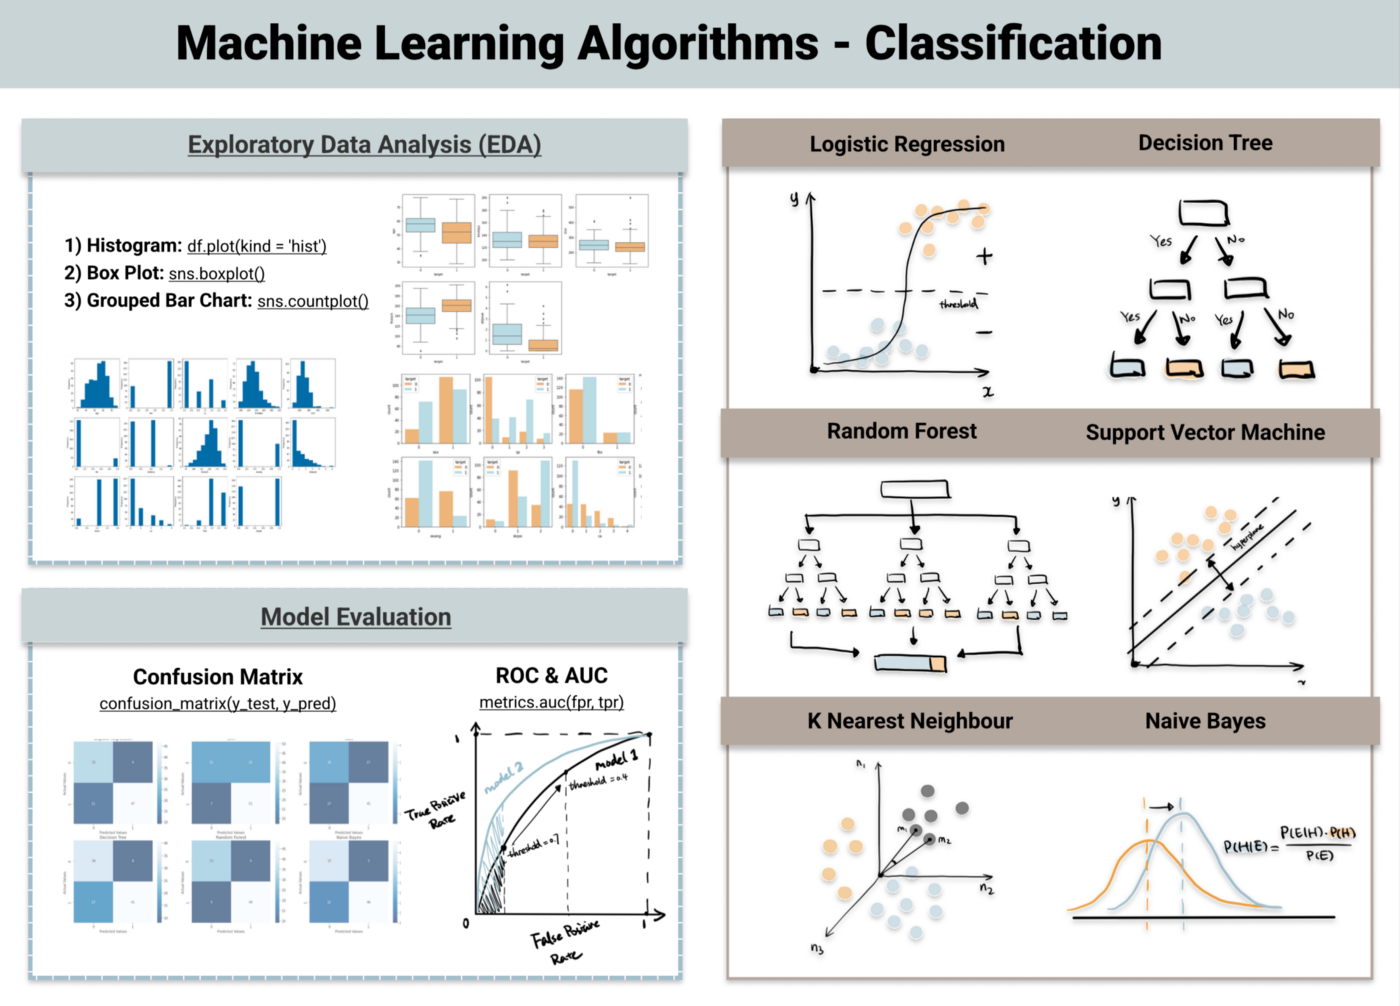

__Deciding on a classifier or classification method is generally very context dependent, and depends on whether you want soft/hard classifications, have many or few classes, have many or few data points, have a training set or not. Even within a given model, we often then have to choose a way to "score" the performance of the model. As with other machine learning methods, you also have to decide on what features to compute or use from the data or things you want to classify.__

## In choosing a classifier, it's important to weight several things:

__Do I care about population statistics? Does this classifier create a really complex selection function?
How fast do I need the prediction to be?
How much data do I have?
How many features do I have? (i.e. dimensionality)
There are__

### To name a few classifiers:

## Nearest neighbor (discriminative):
+Very simple  
+Can compare well to very complicated methods if you have a lot of data  
+Non-parametric representation of complex decision boundaries "for free"  
-Doesn't scale well to high dimensions  
-Have to weight features or normalize in some way to compute distance  
-Slow prediction (no real training)  
## (Naive) Bayes (generative):
+Approximation to Bayesian hierarchical inference  
+Simple, and therefore fast  
+Interpretable, especially if your density distributions are probability distributions  
+Can handle missing data  
-Naive Bayes can't handle correlated features (generic Bayes is fine though)  
## Decision trees / random forest (discriminative):
+Non-parametric  
+Handles high-dimensional feature spaces  
+Will tell you what features are most discriminating  
-Have to rebuild full tree any time you get new data  
-Susceptible to over-fitting  
## Neural networks (discriminative or generative):
+Non-parametric  
+Can extend to handle convolutional relationships between features  
+All the rage right now, so good tools exist  
-Designing good network architectures is an art, often done by intuition, not theory  
-Generally require a lot of data and time to train  
-Not interpretable  

In [124]:
data = fetch_sdss_corrected_spectra()

In [125]:
data.keys()

KeysView(<numpy.lib.npyio.NpzFile object at 0x7fcad50208b0>)

In [126]:
nspectra = len(data['lineindex_cln'])
y = np.zeros(nspectra)
y[data['lineindex_cln'] == 4] = 1
y[data['lineindex_cln'] == 5] = 2

In [127]:
data['log_NII_Ha'], data['log_OIII_Hb']

(array([-0.96828765,  0.        ,  0.        , ..., -0.2997423 ,
         0.        , -0.15449859], dtype=float32),
 array([ 0.48450038,  0.        ,  0.        , ..., -0.17976978,
         0.        , -0.10466351], dtype=float32))

Text(0, 0.5, '$\\log \\left( [{\\rm OIII}] / {\\rm H}\\beta \\right)$')

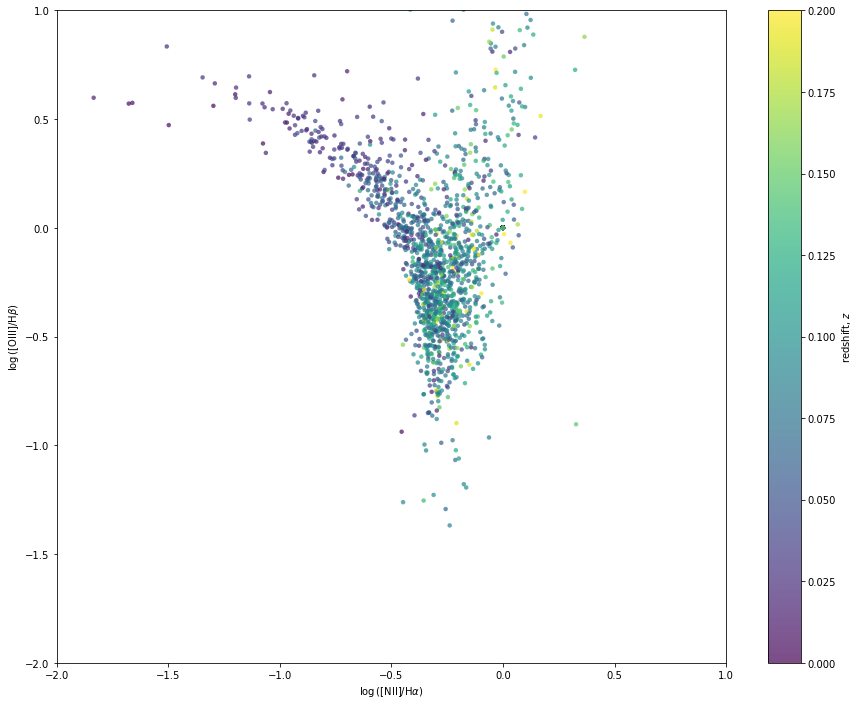

In [128]:
fig, ax = plt.subplots(figsize=(15,12))
cs = ax.scatter(data['log_NII_Ha'], data['log_OIII_Hb'], 
                c=data['z'], vmin=0, vmax=0.2,
                marker='o', s=20, linewidth=0, alpha=0.7)
ax.set_xlim(-2, 1)
ax.set_ylim(-2, 1)
cb = fig.colorbar(cs)
cb.set_label('redshift, $z$')
ax.set_xlabel(r'$\log \left( [{\rm NII}] / {\rm H}\alpha \right)$')
ax.set_ylabel(r'$\log \left( [{\rm OIII}] / {\rm H}\beta \right)$')

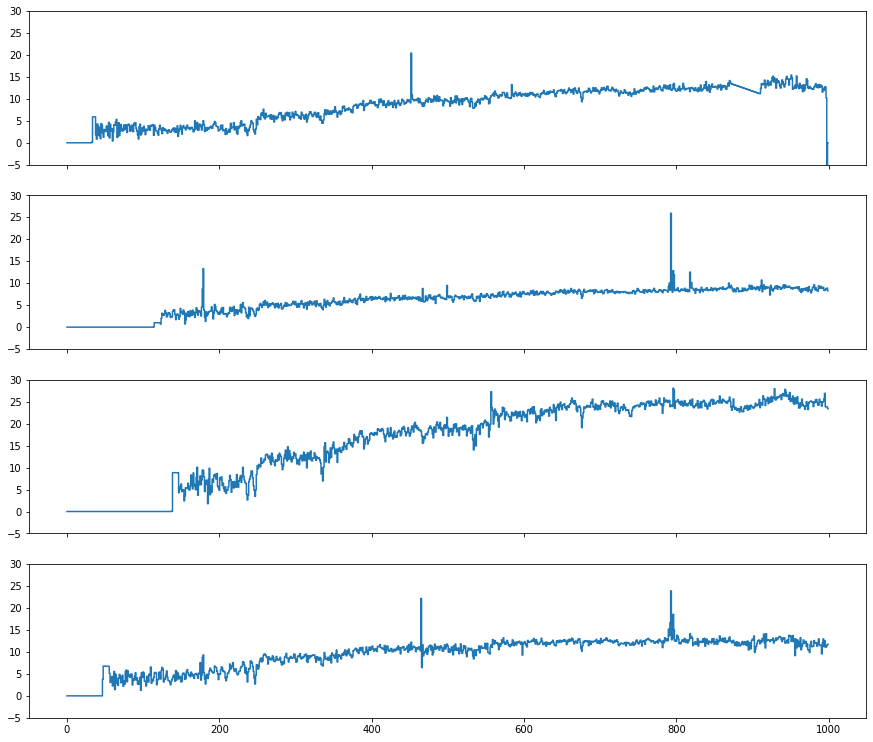

In [129]:
# We're going to prepare two feature sets that we'll use in various applications:
# A small section of the spectrum (~40 pixels or features)
# he full spectra themselves (they have been put onto the same wavelength grid)

rnd = np.random.RandomState(seed=42)

fig, axes = plt.subplots(4, 1, figsize=(15, 13), sharex=True, sharey=True)

for ax, i in zip(axes, rnd.choice(nspectra, size=len(axes), replace=False)):
    ax.plot(data['spectra'][i], marker='', drawstyle='steps-mid')
    ax.set_ylim(-5, 30)

In [130]:
X_spec_mini = data['spectra'][:, 200:240]
X_spec = data['spectra']
X_spec_mini.shape, X_spec.shape

((4000, 40), (4000, 1000))

Mini-Spectra


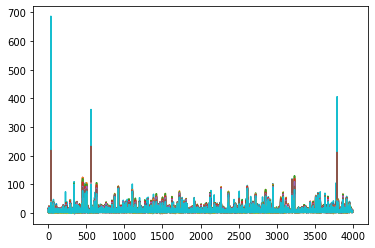

In [131]:
plt.plot(X_spec_mini)
print("Mini-Spectra")

full-Spectra


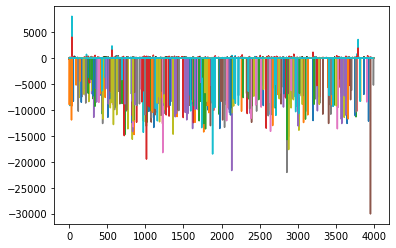

In [132]:
plt.plot(X_spec)
print("full-Spectra")

## K Nearest Neighbors
__We'll see how well we can do at predicting whether an object is an AGN vs. an HII region with KNN, after optimizing over the number of neighbors, K. For this example, we'll just use the line ratio data.__ 

__Convention is to define the classifier object as "clf". For the simplest version of this algorithm, it has 1 tunable parameter: the number of neighbors K to consider.__

In [133]:
from sklearn.neighbors import KNeighborsClassifier

In [134]:
clf = KNeighborsClassifier(n_neighbors=5)

*__Let's start by fitting the classifier to all but the last 130 objects, then predict the classes of the last data points. In the case of KNN, what exactly is KNN doing when we "fit" the model? There are no parameters to fit for! Here it's just constructing a tree based on the features to help make the prediction step more efficient.__*

In [135]:
clf.fit(X_spec_mini[:-130], y[:-130])

KNeighborsClassifier()

In [136]:
y_pred = clf.predict(X_spec_mini[-130:])
y_true = y[-130:]

In [137]:
print("Predicted:", y_pred[:20])
print("True:     ", y_true[:20])
# Our prediction is very good.

Predicted: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
True:      [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.]


__Nice, our predictions are pretty good! But how do we evaluate how well our classifier is doing? We need to compute some kind of "score" for our classifier. In machine learning, this is often the most subtle challenge in the methodology. Be aware that scikit-learn often lets you specify or define your own score functions, but for now we're going to table this idea and stick to some simple defaults.__

__For discrete classification, a common score function is the "misclassification error." This is just the fractional number of data points that we incorrectly classified with whatever classification method we used. We can compute this fairly simply, and then take the compliment of the error to compute the "accuracy" of the classifier:__

In [138]:
misclassification_error = np.sum(y_true != y_pred) / len(y_true)  # loved it
accuracy = 1 - misclassification_error
accuracy # decent accuracy

0.8461538461538461

In [139]:
from sklearn.metrics import accuracy_score   # In-built function to calculate the accuracy of the model.
accuracy_score(y_true, y_pred)

0.8461538461538461

In [140]:
cv_clf.best_params_

{'n_neighbors': 12}

#### Exercise:
___How does the accuracy change as you increase the number of neighbors ("K") from 1-10?___

In [141]:
# Good here we get the acccuraty for each value of N in range of 30
Ns = np.arange(1, 30+1)
accs = []
for N in Ns:
    clf = KNeighborsClassifier(n_neighbors=N)
    clf.fit(X_spec_mini[:-1000], y[:-1000])
    
    y_pred = clf.predict(X_spec_mini[-1000:])
    y_true = y[-1000:]
    acc = accuracy_score(y_true, y_pred)
    accs.append(acc)
    
    print("n={0}, accuracy={1:.3f}".format(N, acc))

n=1, accuracy=0.816
n=2, accuracy=0.817
n=3, accuracy=0.828
n=4, accuracy=0.827
n=5, accuracy=0.840
n=6, accuracy=0.849
n=7, accuracy=0.854
n=8, accuracy=0.847
n=9, accuracy=0.844
n=10, accuracy=0.841
n=11, accuracy=0.847
n=12, accuracy=0.850
n=13, accuracy=0.851
n=14, accuracy=0.846
n=15, accuracy=0.844
n=16, accuracy=0.848
n=17, accuracy=0.844
n=18, accuracy=0.845
n=19, accuracy=0.841
n=20, accuracy=0.843
n=21, accuracy=0.840
n=22, accuracy=0.846
n=23, accuracy=0.841
n=24, accuracy=0.843
n=25, accuracy=0.841
n=26, accuracy=0.839
n=27, accuracy=0.838
n=28, accuracy=0.838
n=29, accuracy=0.836
n=30, accuracy=0.837


(0.0, 30.5)

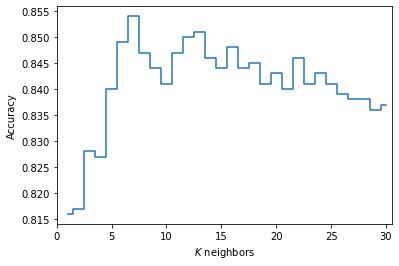

In [142]:
plt.plot(Ns, accs, drawstyle='steps-mid', marker='')
plt.xlabel('$K$ neighbors')
plt.ylabel('Accuracy')
plt.xlim(0, 30.5)

#### Cross-validation
___Cross-validation provides a way to tune or set hyperparameters of machine learning algorithms to try to avoid overfitting to training data. The way these methods generally work for supervised learning problems (like classification) is by training the model on some subset of the full training set, predicting the labels of the held-back data, computing an accuracy metric by comparing to the true labels, then optimizing over the accuracy metric. With jargon, the labeled dataset is typically split into (at least two) subsets called the training data and test data. The models are trained on the training data, and then evaluated on the test data, which the model has never seen before. Provided you separate the train/test data in a sensible way, this gives you an unbiased way to validate the models.___

___Let's now use Sciki-learn's cross-validation score function to automatically do the train-test splitting (multiple times). How does the cross-validation score depend on k, the number of neighbors?___



In [143]:
from sklearn.model_selection import cross_val_score

In [144]:
vals = np.arange(2, 100, 5)
mean_scores = []
for n_neighbors in vals:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(clf, X_spec_mini, y)
    mean_scores.append(np.mean(scores))

Text(0, 0.5, 'Cross-validation accuracy')

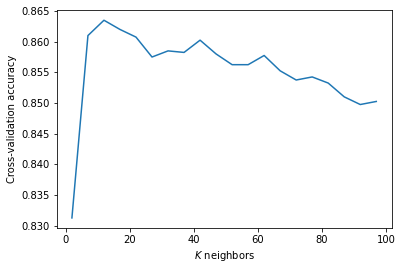

In [145]:
plt.plot(vals, mean_scores)
plt.xlabel('$K$ neighbors')
plt.ylabel('Cross-validation accuracy')

In [146]:
from sklearn.model_selection import GridSearchCV

In [147]:
knn_clf = KNeighborsClassifier()

In [148]:
idx = np.random.choice(len(X_spec_mini), size=len(X_spec_mini), replace=False)

# 85% training data, 15% test data
split = int(0.85 * len(X_spec_mini))

train_X = X_spec_mini[idx[:split]]
train_y = y[idx[:split]]

test_X = X_spec_mini[idx[split:]]
test_y = y[idx[split:]]

In [149]:
params = {'n_neighbors': np.arange(2, 30, 1)}
cv_clf = GridSearchCV(knn_clf, param_grid=params)
cv_clf.fit(X_spec_mini, y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [150]:
cv_clf.best_score_

0.8634999999999999

In [151]:
cv_clf.best_params_

{'n_neighbors': 12}

------
-----
-----

## Naive Bayes
___With Gaussians!___

In [152]:
from sklearn.naive_bayes import GaussianNB

In [153]:
clf = GaussianNB()
clf.fit(X_spec_mini, y)

GaussianNB()

In [154]:
y_pred = clf.predict(X_spec_mini)
accuracy_score(y, y_pred)

0.644

In [155]:
# Why does Gaussian Naive Bayes perform so much worse than nearest neighbors?
# A general difference between KNN and other models is the large real time computation needed by KNN compared to others.
# KNN vs naive bayes : Naive bayes is much faster than KNN due to KNN's real-time execution. 
# Naive bayes is parametric whereas KNN is non-parametric.

In [156]:
x1 = np.random.multivariate_normal([1, 1], np.array([[0.5, 0.499], [0.499, 0.5]])**2, size=1000)
x2 = np.random.multivariate_normal([1, 1], np.array([[0.5**2, -0.499**2], [-0.499**2, 0.5**2]]), size=1000)
X_patho = np.vstack((x1, x2))
y_patho = np.concatenate((np.zeros(len(x1)), np.ones(len(x2))))

# shuffle
idx = np.random.choice(X_patho.shape[0], size=X_patho.shape[0], replace=False)
X_patho = X_patho[idx]
y_patho = y_patho[idx]

(-1.0, 3.0)

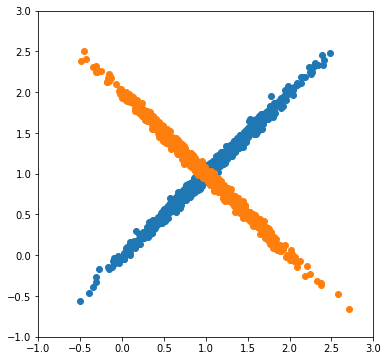

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x1[:, 0], x1[:, 1])
ax.scatter(x2[:, 0], x2[:, 1])
ax.set_xlim(-1, 3)
ax.set_ylim(-1, 3)

In [158]:
gnb = GaussianNB()
gnb.fit(X_patho[:-128], y_patho[:-128])

GaussianNB()

In [159]:
y_patho_pred = gnb.predict(X_patho[-128:])
accuracy_score(y_patho[-128:], y_patho_pred)

0.5625

Decision trees
Make binary decisions for each feature with decision boundaries perpendicular to feature axes. Need to specify the depth/height of the tree, $D$ this partitions the feature space into $2^{D}$  regions. Can set $D$ with cross-validation!

Can improve bias and variance using boosting, bagging.

For now, we'll just use a vanilla decision tree, but using the full spectrum as our feature set.

In [160]:
from sklearn.tree import DecisionTreeClassifier

In [161]:
clf = DecisionTreeClassifier(max_depth=8, 
                             min_samples_split=2, 
                             min_samples_leaf=1)

In [162]:
clf.fit(X_spec[:-1024], y[:-1024])

DecisionTreeClassifier(max_depth=8)

In [163]:
y_pred = clf.predict(X_spec[-1024:])
accuracy_score(y[-1024:], y_pred[-1024:])
# almost 90% accuracy.

0.8984375

In [165]:
clf.max_depth

8